In [ ]:
from google.colab import files
from google.colab import drive #menghubungkan ke google colab dengan gdrive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

images = []
label = []
import os
for dirname, _, filenames in os.walk("/content/drive/MyDrive/Colab Notebooks/Dataset/"):
    for filename in filenames:
        images.append(os.path.join(filename).split('/')[-1])
        label.append(os.path.join(dirname).split('/')[-1])

In [ ]:
import torch
import torchvision
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt #visualisasi data statistik
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from PIL import Image
import random
import time
from tqdm.notebook import tqdm #visualisasi progress bar
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MENAMPILKAN TOTAL KESELURUHAN DATA

In [ ]:
IMAGE = "/content/drive/MyDrive/Colab Notebooks/Dataset/"
TARGET_LABEL = {'jalan_lubang': 0, 
                'jalan_retak': 1, 
                'jalan_tidak_rusak': 2}

df = pd.DataFrame({'image':images, 'label': label})
df

,image,label
0,108.jpg,jalan_lubang
1,105.jpg,jalan_lubang
2,109.jpg,jalan_lubang
3,107.jpg,jalan_lubang
4,104.jpg,jalan_lubang
...,...,...
729,33.jpg,jalan_tidak_rusak
730,9.jpg,jalan_tidak_rusak
731,136.jpg,jalan_tidak_rusak
732,165.jpg,jalan_tidak_rusak


PIE CHART TABLE

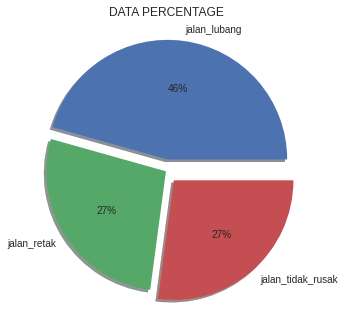

In [ ]:
label, count = np.unique(df['label'].values, return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = label, explode=[0.1, 0, 0.1],  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

TAHAP INISIALISASI INPUTAN

TAHAP ANOTASI DATA MENJADI DATA TRAIN, VAL DAN TES

In [ ]:
class Jalanan(Dataset):
    def __init__(self, x, y, path, map_label=TARGET_LABEL, transform=None): # INISIALISASI PARAMETER INPUT
        self.X = x 
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
        
    def __getitem__(self, idx): #INIT FUNGSI MENGAMBIL DATASET
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self): #INIT JUMLAH BANYAK DATA ATAUPUN PARAM
        return len(self.X)
    
X_trainval, X_test, y_trainval, y_test = train_test_split( #PARAM DATA TES
    df['image'].values, df['label'].values, 
    test_size=0.15, stratify=df['label'].values, 
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split( #PARAM DATA TRAIN & VALIDASI
    X_trainval, y_trainval, 
    stratify=y_trainval, test_size=0.15,
    random_state=77)
print('DATA TRAIN:', len(X_train),
      '\nDATA VAL TRAIN:', len(X_val),
      '\nDATA TEST:', len(X_test))

DATA TRAIN: 529 
DATA VAL TRAIN: 94 
DATA TEST: 111


TAHAP PRE-PROCESSING

In [ ]:
#DATALOADER
# mean = [0.5548598 , 0.54704523, 0.54043627] 
# std = [0.1071739 , 0.10524916, 0.10435305]
mean = [0.4940, 0.4921, 0.4831]
std = [0.1412, 0.1394, 0.1390]
batch_size = 24

train_transform = T.Compose([T.Resize((128, 128)), #PRE-PROCESSING
                             T.ToTensor(),   
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.Grayscale(num_output_channels=3),
                            #  T.GaussianBlur(3, sigma=(1.0, 1.49)),
                            #  T.ColorJitter(brightness=0, contrast=0 , saturation=0, hue= 0.0 ),
                             T.RandomErasing(scale=(0.01, 0.2)),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)), #PROCESSING
                           T.ToTensor(),
                           T.Grayscale(num_output_channels=3),                             
                           T.GaussianBlur(3, sigma=(1.0, 2.0)),
                           T.ColorJitter(brightness=1, contrast=0 , saturation=0, hue= 0.0 ),
                           T.Normalize(mean, std)
                          ])

train_set = Jalanan(X_train, y_train, IMAGE, transform=train_transform) 
val_set = Jalanan(X_val, y_val, IMAGE, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=0, pin_memory=True)

TAMPILKAN HASIL PRE-PROCESSING

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


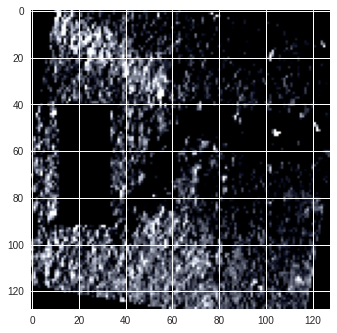

In [ ]:
img, label = train_set[random.randint(0, len(X_train))]

plt.imshow(img.permute(1,2,0))

IMPORT MODE ARSITEKTUR RESNET34

In [ ]:
model = torchvision.models.resnet34(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
#model.classifier[6] = nn.Linear(4096, 20)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

tahap pelatihan -> data latih dan validasi

In [ ]:
def accuracy(output, label): #FUNGSI HITUNG AKURASI TRAIN 
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss() #menghitung probabilitas pada hasil fungsi aktivasi softmax
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

Mulai melatih data

In [ ]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
times = []
for e in range(epoch):
    model.to(device)
    model.train()
    
    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        
        train_loss += loss
        train_acc += accuracy(output, label)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    else:
        with torch.no_grad():
            model.eval()
            
            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss
                
    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))

    times.append(time.time() - since)
    
    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )
    
print(sum(times))


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 1/20.. train loss 2.985.. val loss 1.531.. train accuracy 0.502.. val accuracy 0.671.. time 444.107 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 2/20.. train loss 0.480.. val loss 1.606.. train accuracy 0.817.. val accuracy 0.650.. time 480.271 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 3/20.. train loss 1.863.. val loss 0.802.. train accuracy 0.467.. val accuracy 0.608.. time 581.169 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 4/20.. train loss 1.245.. val loss 1.133.. train accuracy 0.435.. val accuracy 0.329.. time 440.045 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 5/20.. train loss 1.160.. val loss 1.251.. train accuracy 0.525.. val accuracy 0.458.. time 439.631 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 6/20.. train loss 3.127.. val loss 1.186.. train accuracy 0.469.. val accuracy 0.458.. time 437.663 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 7/20.. train loss 1.351.. val loss 1.554.. train accuracy 0.370.. val accuracy 0.458.. time 439.467 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 8/20.. train loss 1.446.. val loss 8.273.. train accuracy 0.364.. val accuracy 0.458.. time 434.719 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 9/20.. train loss 1.401.. val loss 1.267.. train accuracy 0.464.. val accuracy 0.458.. time 431.672 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 10/20.. train loss 0.896.. val loss 2.840.. train accuracy 0.569.. val accuracy 0.458.. time 430.888 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 11/20.. train loss 1.597.. val loss 1.146.. train accuracy 0.420.. val accuracy 0.458.. time 431.130 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 12/20.. train loss 1.125.. val loss 1.077.. train accuracy 0.433.. val accuracy 0.458.. time 430.621 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 13/20.. train loss 1.073.. val loss 1.074.. train accuracy 0.446.. val accuracy 0.458.. time 430.683 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 14/20.. train loss 1.109.. val loss 1.070.. train accuracy 0.437.. val accuracy 0.458.. time 430.880 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 15/20.. train loss 1.082.. val loss 1.075.. train accuracy 0.417.. val accuracy 0.458.. time 429.588 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 16/20.. train loss 1.075.. val loss 1.068.. train accuracy 0.466.. val accuracy 0.458.. time 432.888 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 17/20.. train loss 1.101.. val loss 1.069.. train accuracy 0.433.. val accuracy 0.458.. time 431.964 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 18/20.. train loss 1.076.. val loss 1.068.. train accuracy 0.480.. val accuracy 0.458.. time 431.352 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 19/20.. train loss 1.084.. val loss 1.068.. train accuracy 0.437.. val accuracy 0.458.. time 432.169 s


  0%|          | 0/23 [00:00<?, ?it/s]

epochs 20/20.. train loss 1.085.. val loss 1.068.. train accuracy 0.444.. val accuracy 0.458.. time 432.989 s
8873.896964788437


In [ ]:
time_str = float(sum(times))
print('total waktu {:.3f} s'.format(time_str))
# print(time_str)

total waktu 8873.897 s


menampilkan grafik akurasi dan loss

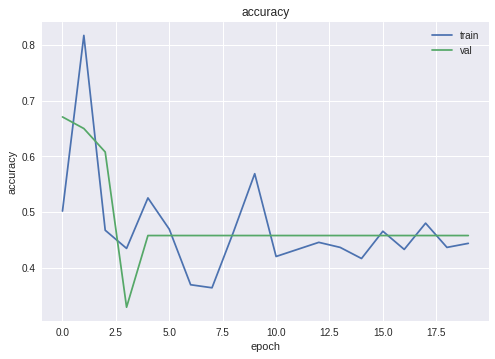

In [ ]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

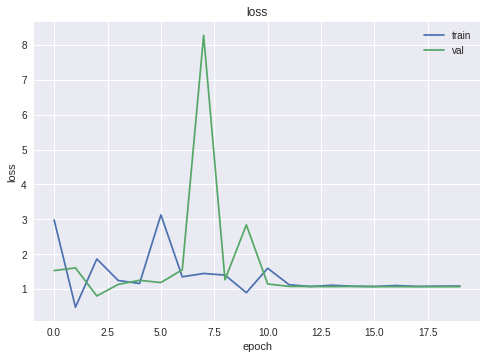

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend()
plt.show()

MENAMPILKAN DATA UJI

In [ ]:
test_set = Jalanan(X_test, y_test, IMAGE, transform=val_transform) #

def predict(model, img, label):  #FUNGSI memprediksi hasil data uji
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

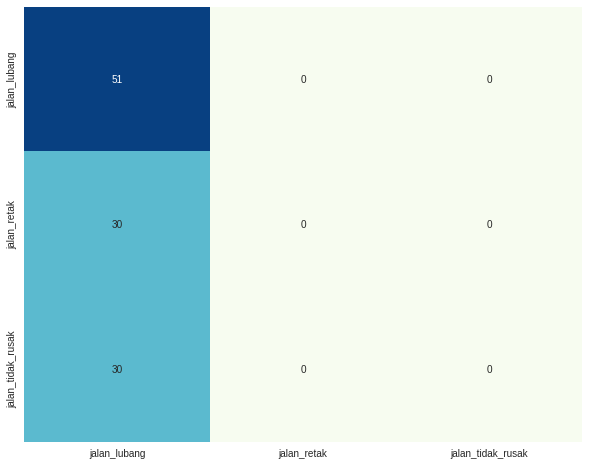

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.yticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))


              precision    recall  f1-score   support

           0       0.46      1.00      0.63        51
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        30

    accuracy                           0.46       111
   macro avg       0.15      0.33      0.21       111
weighted avg       0.21      0.46      0.29       111



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


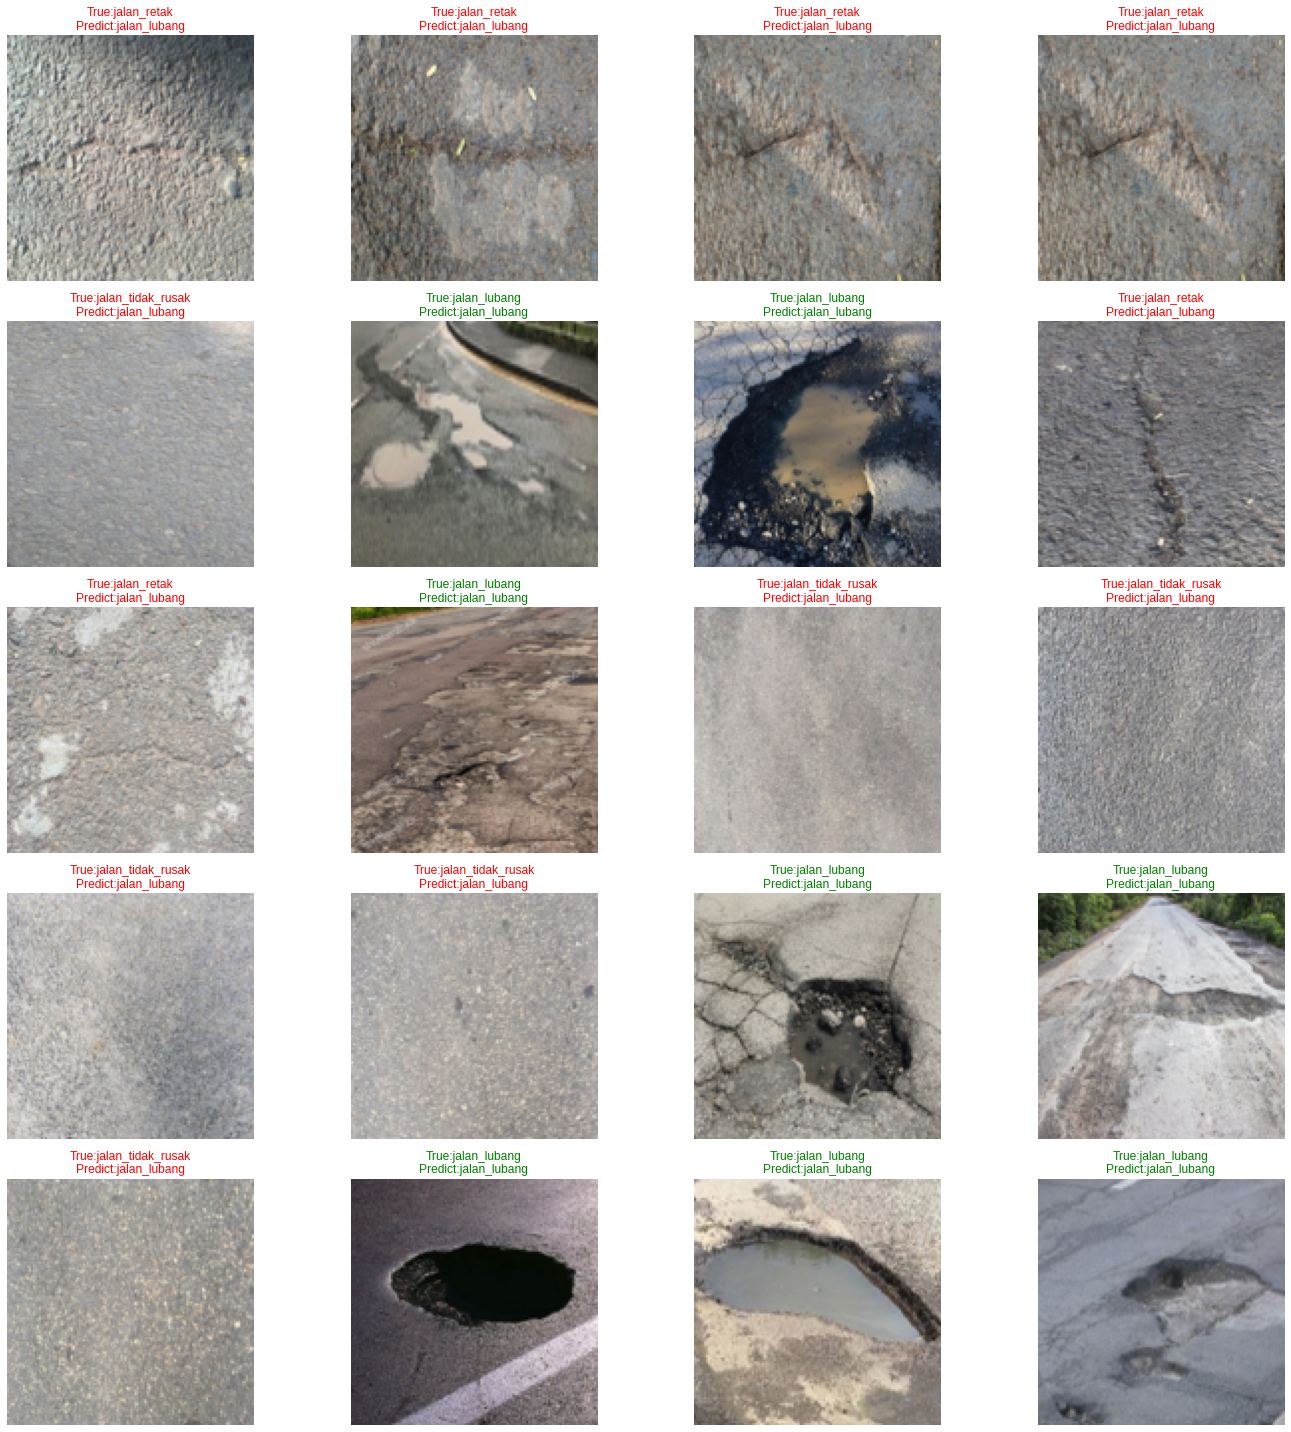

In [ ]:
ints_2_label = {0: 'jalan_lubang',  #INISIALISASI OUTPUT
                1: 'jalan_retak', 
                2: 'jalan_tidak_rusak'}

random_selection = np.random.randint(0, len(test_predict), 20)

fig = plt.figure(figsize=(20, 20)) #MENAMPILKAN GAMBAR UKURAN 20X20

test_set = Jalanan(X_test, y_test, IMAGE, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(5, 4, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(ints_2_label[label], ints_2_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() #want faster comment or delete this
plt.show()

MENAMPILKAN HASIL AKURASI

In [ ]:
ints_2_label = {0: 'jalan_lubang', 
                1: 'jalan_retak', 
                2: 'jalan_tidak_rusak'}

random_selection = np.random.randint(0, len(test_predict), 111)

test_set = Jalanan(X_test, y_test, IMAGE, transform=T.Resize((124,124)))
predict_2= []
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    if label == test_predict[idx]:
      predict_2.append(i)

print(len(predict_2)/len(random_selection))
# print(len(predict_1)/len(random_selection))
# print(len(predict_0)/len(random_selection))

0.44144144144144143
